<a href="https://colab.research.google.com/github/bethuunltd/Weather-Prediction/blob/main/SeasonalSeqwithAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler

# Load & parse
df = pd.read_csv('data1.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df[['ws']]

# STL decomposition (no data leakage — okay pre-split)
stl = STL(df['ws'], period=24)
res = stl.fit()
df['trend'] = res.trend
df['residual'] = res.resid

# Time features (okay pre-split)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Split FIRST (before scaling)
train_len = int(0.7 * len(df))
val_len = int(0.15 * len(df))

train_df = df.iloc[:train_len].copy()
val_df = df.iloc[train_len:train_len + val_len].copy()
test_df = df.iloc[train_len + val_len:].copy()

# Columns to scale
input_features = ['residual', 'trend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

# Fit scalers only on train
scalers = {col: MinMaxScaler() for col in input_features}
for col in input_features:
    train_df[col] = scalers[col].fit_transform(train_df[[col]])
    val_df[col]   = scalers[col].transform(val_df[[col]])
    test_df[col]  = scalers[col].transform(test_df[[col]])

# Targets
resid_scaler = MinMaxScaler()
trend_scaler = MinMaxScaler()
train_df['target_resid'] = resid_scaler.fit_transform(train_df[['residual']])
val_df['target_resid'] = resid_scaler.transform(val_df[['residual']])
test_df['target_resid'] = resid_scaler.transform(test_df[['residual']])

train_df['target_trend'] = trend_scaler.fit_transform(train_df[['trend']])
val_df['target_trend'] = trend_scaler.transform(val_df[['trend']])
test_df['target_trend'] = trend_scaler.transform(test_df[['trend']])


In [ ]:
class WeatherDataset(Dataset):
    def __init__(self, df, input_len=24, output_len=12):
        self.df = df
        self.input_len = input_len
        self.output_len = output_len
        self.total_len = input_len + output_len
        self.input_cols = ['residual', 'trend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
        self.trend_col = 'target_trend'
        self.resid_col = 'target_resid'

    def __len__(self):
        return len(self.df) - self.total_len

    def __getitem__(self, idx):
        input_seq = self.df.iloc[idx : idx + self.input_len][self.input_cols].values
        target_trend = self.df.iloc[idx + self.input_len : idx + self.total_len][self.trend_col].values
        target_resid = self.df.iloc[idx + self.input_len : idx + self.total_len][self.resid_col].values

        input_tensor = torch.tensor(input_seq, dtype=torch.float32)                 # (input_len, 6)
        target_tensor = torch.stack([
            torch.tensor(target_trend, dtype=torch.float32),
            torch.tensor(target_resid, dtype=torch.float32)
        ], dim=-1)                                                                  # (output_len, 2)

        return input_tensor, target_tensor


In [ ]:
train_dataset = WeatherDataset(train_df, input_len=12, output_len=3)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
train_dataset = WeatherDataset(train_df,input_len=12,output_len=3)
val_dataset =  WeatherDataset(val_df,input_len=12,output_len=3)
test_dataset =  WeatherDataset(test_df,input_len=12,output_len=3)

batch_size=32
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last = True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,drop_last = True)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_dim,hidden_dim,num_layers=1):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.input_dim = input_dim
    self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)

  def forward(self,x):
    outputs,(h_n,c_n) = self.lstm(x)
    return outputs,h_n,c_n

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        decoder_hidden = decoder_hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
        concat = torch.cat((encoder_outputs, decoder_hidden), dim=2)

        energy = torch.tanh(self.attn(concat))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.attention = BahdanauAttention(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(output_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        # x: (batch, 1, output_dim)
        attn_weights = self.attention(hidden, encoder_outputs)  # (batch, seq_len)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (batch, 1, hidden_dim)

        lstm_input = torch.cat((x, context), dim=2)  # (batch, 1, output_dim + hidden_dim)
        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(outputs)
        return prediction, hidden, cell




class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self,src,target_len,target_seq = None,teacher_forcing_ratio = 0.5):
    batch_size, seq_len, _ = src.size()
    outputs = []

    encoder_outputs,hidden,cell = self.encoder(src)
    input_decoder = src[:, -1:, :2]  #The last know value of windspeed(at hour 24) - Becomes the input for the decoder




    for t in range(target_len):
      output, hidden, cell = self.decoder(input_decoder, hidden, cell, encoder_outputs)
      outputs.append(output)


      if target_seq is not None and torch.rand(1).item () < teacher_forcing_ratio:
        input_decoder = target_seq[:,t:t+1,:] #This is the ground truth input
      else:
        input_decoder = output

    return torch.cat(outputs,dim=1) #Final shape: (batch_size, target_len, output_dim)











In [ ]:
# Updated model hyperparameters
input_dim = 6        # Number of input features: residual, trend, hour_sin, hour_cos, dow_sin, dow_cos
output_dim = 2       # Predicting: trend and residual
hidden_dim = 64
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model instantiation
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)
decoder = Decoder(output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers)
model = Seq2Seq(encoder=encoder, decoder=decoder, device=device).to(device)

# Training hyperparameters
num_epochs = 25
teacher_forcing_ratio = 0.5
clip_grad_norm = 1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

best_val_loss = float('inf')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for src, target in train_loader:
        src, target = src.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(
            src,
            target_len=target.size(1),
            target_seq=target,
            teacher_forcing_ratio=teacher_forcing_ratio
        )  # output: [batch_size, target_len, 2]

        loss = criterion(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    # 🔍 Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src_val, target_val in val_loader:
            src_val, target_val = src_val.to(device), target_val.to(device)
            output_val = model(src_val, target_len=target_val.size(1), target_seq=None, teacher_forcing_ratio=0.0)
            val_loss += criterion(output_val, target_val).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_seq2seq_model.pt')
        print("✅ Saved new best model!")

Epoch [1/25] - Loss: 0.0040
Validation Loss: 0.0021
✅ Saved new best model!


KeyboardInterrupt: 

✅ RMSE: 0.0620
✅ R² Score: 0.8762


/tmp/ipython-input-7-1664434353.py:59: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-1664434353.py:60: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.savefig("wind_seq2seq_trend_resid.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


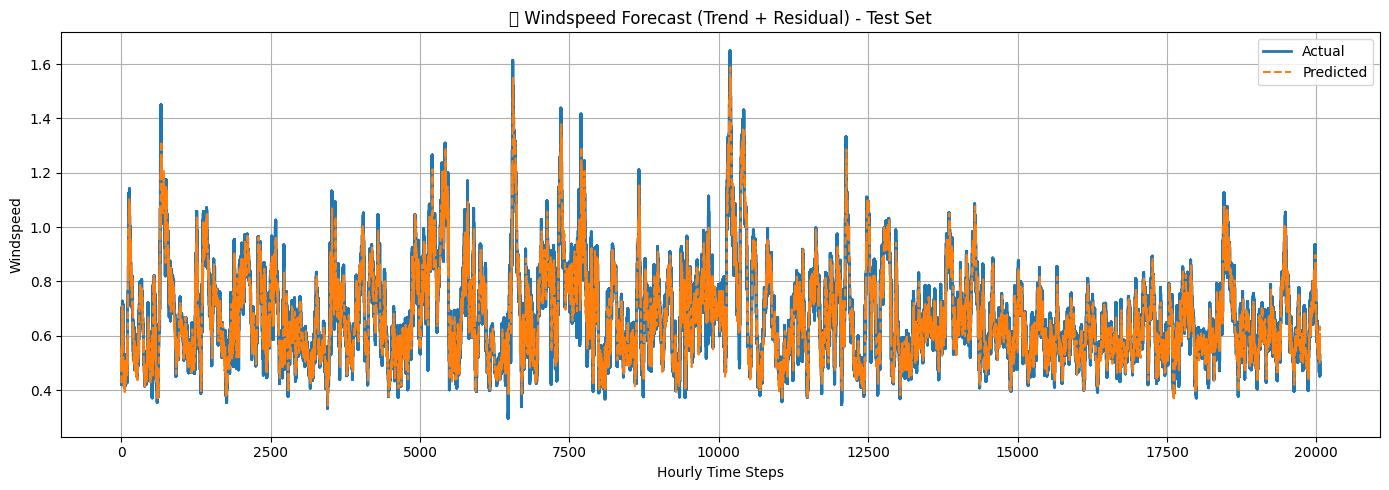

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch

# 📦 Load best model
model.load_state_dict(torch.load('attention_best_seq2seq_model.pt', map_location=torch.device('cpu')))
device = torch.device('cpu')
model.to(device)
model.eval()

# 🔍 Run model over entire test set
all_preds = []
all_trues = []

with torch.no_grad():
    for src_batch, target_batch in test_loader:
        src_batch = src_batch.to(device)
        target_batch = target_batch.to(device)

        output_batch = model(
            src_batch,
            target_len=target_batch.size(1),
            target_seq=None,
            teacher_forcing_ratio=0.0
        )

        all_preds.append(output_batch.cpu())
        all_trues.append(target_batch.cpu())

# 🧱 Stack and reshape to (N, 2) for [trend, residual]
pred_full = torch.cat(all_preds, dim=0).reshape(-1, 2).numpy()
true_full = torch.cat(all_trues, dim=0).reshape(-1, 2).numpy()

# 🔄 Inverse scaling
pred_trend_inv = trend_scaler.inverse_transform(pred_full[:, 0].reshape(-1, 1)).flatten()
pred_resid_inv = resid_scaler.inverse_transform(pred_full[:, 1].reshape(-1, 1)).flatten()
true_trend_inv = trend_scaler.inverse_transform(true_full[:, 0].reshape(-1, 1)).flatten()
true_resid_inv = resid_scaler.inverse_transform(true_full[:, 1].reshape(-1, 1)).flatten()

# ➕ Combine trend and residual components
pred_total = pred_trend_inv + pred_resid_inv
true_total = true_trend_inv + true_resid_inv

# 📉 Evaluation metrics
rmse = mean_squared_error(true_total, pred_total) ** 0.5
r2 = r2_score(true_total, pred_total)
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 📊 Plot
plt.figure(figsize=(14, 5))
plt.plot(true_total, label='Actual', linewidth=2)
plt.plot(pred_total, label='Predicted', linestyle='--')
plt.title("🌬️ Windspeed Forecast (Trend + Residual) - Test Set")
plt.xlabel("Hourly Time Steps")
plt.ylabel("Windspeed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("wind_seq2seq_trend_resid.png", dpi=600)
plt.show()


/tmp/ipython-input-8-1680731006.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_index, periods=forecast_horizon + 24, freq='H')
/tmp/ipython-input-8-1680731006.py:82: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1680731006.py:83: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig("recursive_forecast_seq2seq.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


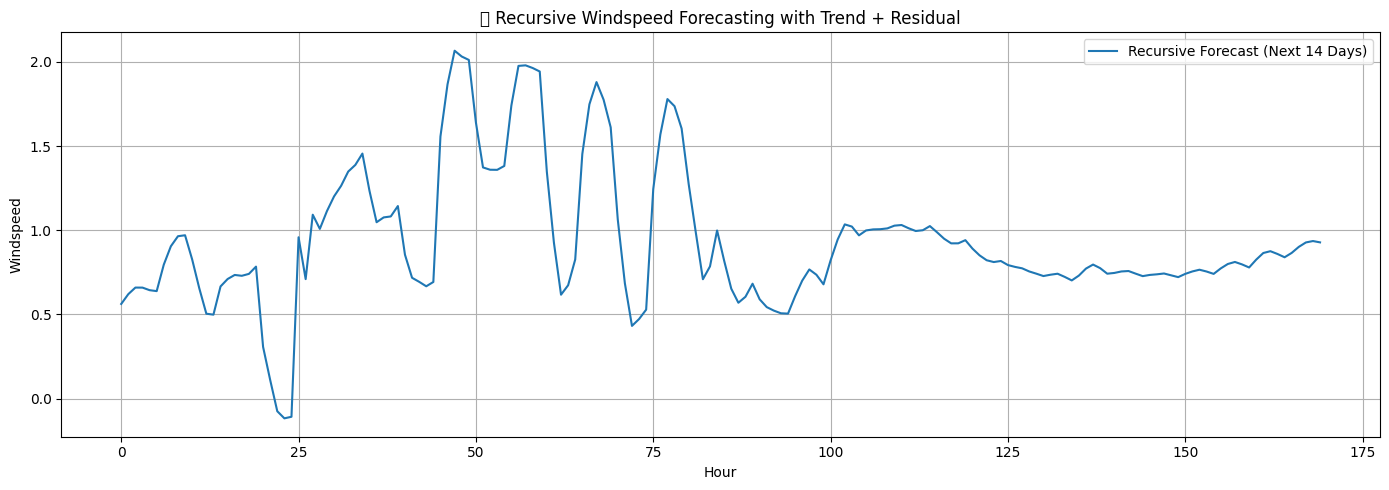

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

input_len=16
#output_len=3
output_len = 5

# Assume: test_df, input_len, output_len, model, trend_scaler, resid_scaler already exist

device = torch.device('cpu')
model.load_state_dict(torch.load("attention_best_seq2seq_model.pt", map_location=device))
model.to(device)
model.eval()

forecast_horizon = 168  # 14 days × 24 hours
input_window = input_len
step_size = output_len

# Get the last input window
initial_input = torch.tensor(
    test_df.iloc[-input_window:][['residual', 'trend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']].values,
    dtype=torch.float32
).unsqueeze(0).to(device)

predictions_trend = []
predictions_resid = []

with torch.no_grad():
    current_input = initial_input.clone()
    start_index = test_df.index[-1] + pd.Timedelta(hours=1)
    time_range = pd.date_range(start=start_index, periods=forecast_horizon + 24, freq='H')

    for i in range(0, forecast_horizon, step_size):
        output = model(current_input, target_len=step_size, target_seq=None, teacher_forcing_ratio=0.0)
        output = output.squeeze(0).cpu().numpy()  # [step_size, 2]

        pred_trend = output[:, 0]
        pred_resid = output[:, 1]

        predictions_trend.append(pred_trend)
        predictions_resid.append(pred_resid)

        # Prepare cyclic features for next step
        next_hours = time_range[i:i+step_size]
        hour_sin = np.sin(2 * np.pi * next_hours.hour / 24)
        hour_cos = np.cos(2 * np.pi * next_hours.hour / 24)
        dow_sin = np.sin(2 * np.pi * next_hours.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * next_hours.dayofweek / 7)

        new_input_block = np.stack([
            pred_resid,
            pred_trend,
            hour_sin,
            hour_cos,
            dow_sin,
            dow_cos
        ], axis=1)  # [step_size, 6]

        prev_input_np = current_input.squeeze(0).cpu().numpy()
        updated_input = np.concatenate([prev_input_np, new_input_block], axis=0)[-input_window:]
        current_input = torch.tensor(updated_input, dtype=torch.float32).unsqueeze(0).to(device)

# Inverse scale and combine
trend_preds = np.concatenate(predictions_trend).reshape(-1, 1)
resid_preds = np.concatenate(predictions_resid).reshape(-1, 1)

trend_real = trend_scaler.inverse_transform(trend_preds)
resid_real = resid_scaler.inverse_transform(resid_preds)

final_forecast = trend_real + resid_real  # Total forecast

# Plot
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label="Recursive Forecast (Next 14 Days)", color='tab:blue')
plt.title("🔁 Recursive Windspeed Forecasting with Trend + Residual")
plt.xlabel("Hour")
plt.ylabel("Windspeed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("recursive_forecast_seq2seq.png", dpi=600)
plt.show()


/tmp/ipython-input-15-1764249292.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_index, periods=forecast_horizon + 24, freq='H')
/tmp/ipython-input-15-1764249292.py:83: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-1764249292.py:84: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig("recursive_forecast_seq2seq.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


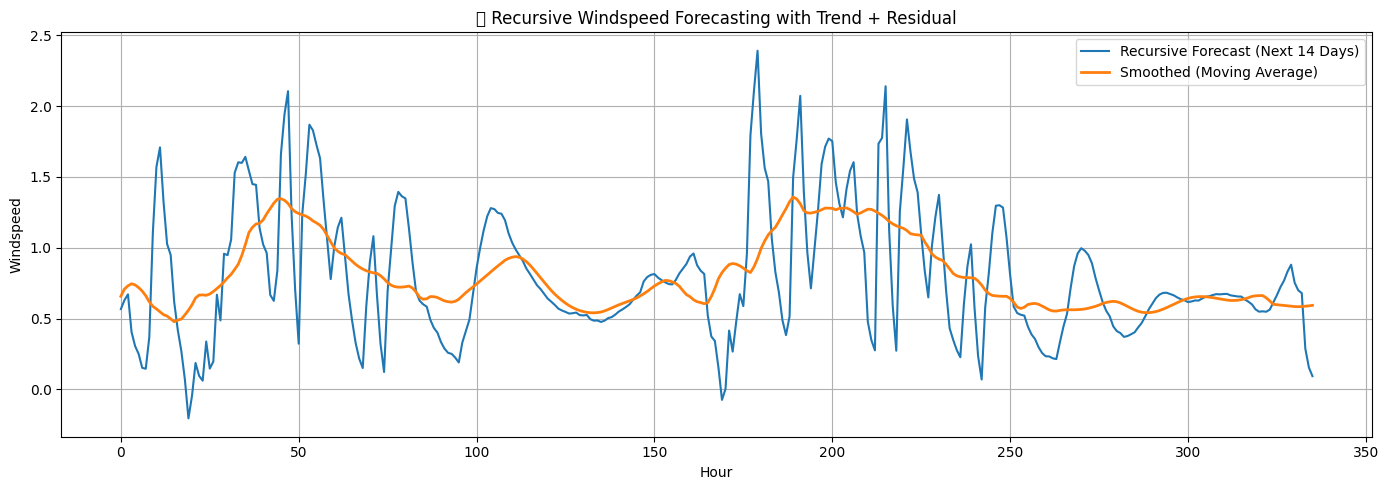

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

input_len=12
output_len=3
# Assume: test_df, input_len, output_len, model, trend_scaler, resid_scaler already exist

device = torch.device('cpu')
model.load_state_dict(torch.load("attention_best_seq2seq_model.pt", map_location=device))
model.to(device)
model.eval()

forecast_horizon = 336  # 14 days × 24 hours
input_window = input_len
step_size = output_len

# Get the last input window
initial_input = torch.tensor(
    test_df.iloc[-input_window:][['residual', 'trend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']].values,
    dtype=torch.float32
).unsqueeze(0).to(device)

predictions_trend = []
predictions_resid = []

with torch.no_grad():
    current_input = initial_input.clone()
    start_index = test_df.index[-1] + pd.Timedelta(hours=1)
    time_range = pd.date_range(start=start_index, periods=forecast_horizon + 24, freq='H')

    for i in range(0, forecast_horizon, step_size):
        output = model(current_input, target_len=step_size, target_seq=None, teacher_forcing_ratio=0.0)
        output = output.squeeze(0).cpu().numpy()  # [step_size, 2]

        pred_trend = output[:, 0]
        pred_resid = output[:, 1]

        predictions_trend.append(pred_trend)
        predictions_resid.append(pred_resid)

        # Prepare cyclic features for next step
        next_hours = time_range[i:i+step_size]
        hour_sin = np.sin(2 * np.pi * next_hours.hour / 24)
        hour_cos = np.cos(2 * np.pi * next_hours.hour / 24)
        dow_sin = np.sin(2 * np.pi * next_hours.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * next_hours.dayofweek / 7)

        new_input_block = np.stack([
            pred_resid,
            pred_trend,
            hour_sin,
            hour_cos,
            dow_sin,
            dow_cos
        ], axis=1)  # [step_size, 6]

        prev_input_np = current_input.squeeze(0).cpu().numpy()
        updated_input = np.concatenate([prev_input_np, new_input_block], axis=0)[-input_window:]
        current_input = torch.tensor(updated_input, dtype=torch.float32).unsqueeze(0).to(device)

# Inverse scale and combine
trend_preds = np.concatenate(predictions_trend).reshape(-1, 1)
resid_preds = np.concatenate(predictions_resid).reshape(-1, 1)

trend_real = trend_scaler.inverse_transform(trend_preds)
resid_real = resid_scaler.inverse_transform(resid_preds)

final_forecast = trend_real + resid_real  # Total forecast
forecast_series = pd.Series(final_forecast.squeeze(1))
smoothed_forecast = forecast_series.rolling(window=24, min_periods=1, center=True).mean().values

# Plot
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label="Recursive Forecast (Next 14 Days)", color='tab:blue')
plt.plot(smoothed_forecast, label="Smoothed (Moving Average)", color='tab:orange', linewidth=2)
plt.title("🔁 Recursive Windspeed Forecasting with Trend + Residual")
plt.xlabel("Hour")
plt.ylabel("Windspeed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("recursive_forecast_seq2seq.png", dpi=600)
plt.show()


/tmp/ipython-input-16-2234157347.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_index, periods=forecast_horizon + 24, freq='H')
/tmp/ipython-input-16-2234157347.py:84: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-2234157347.py:85: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig("recursive_forecast_seq2seq_smoothed.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


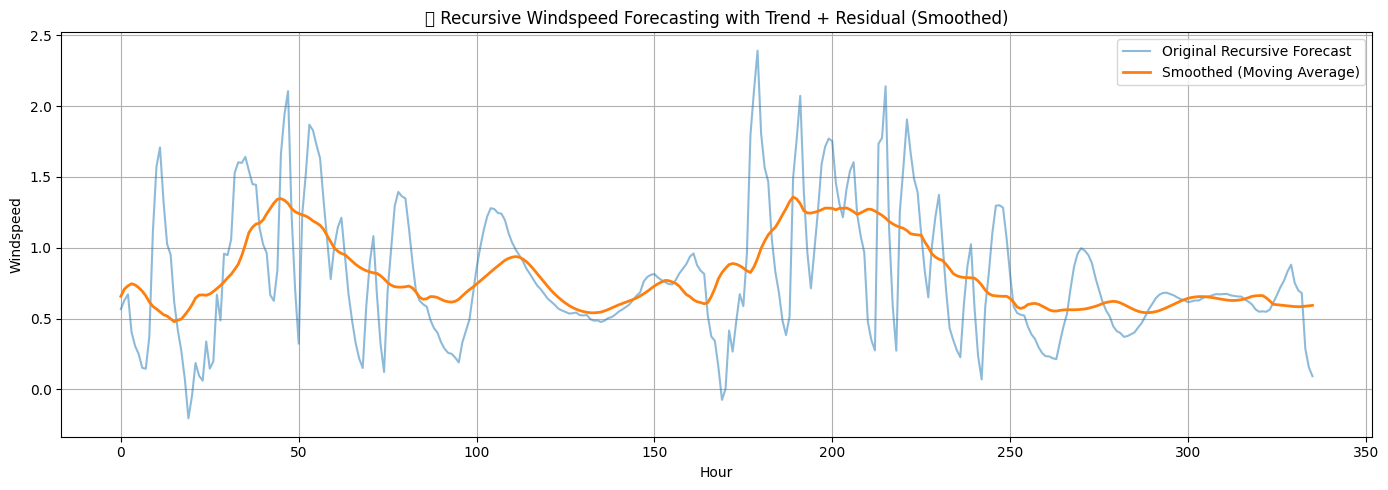

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

input_len = 12
output_len = 3

device = torch.device('cpu')
model.load_state_dict(torch.load("attention_best_seq2seq_model.pt", map_location=device))
model.to(device)
model.eval()

forecast_horizon = 336  # 14 days × 24 hours
input_window = input_len
step_size = output_len

# Get the last input window
initial_input = torch.tensor(
    test_df.iloc[-input_window:][['residual', 'trend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']].values,
    dtype=torch.float32
).unsqueeze(0).to(device)

predictions_trend = []
predictions_resid = []

with torch.no_grad():
    current_input = initial_input.clone()
    start_index = test_df.index[-1] + pd.Timedelta(hours=1)
    time_range = pd.date_range(start=start_index, periods=forecast_horizon + 24, freq='H')

    for i in range(0, forecast_horizon, step_size):
        output = model(current_input, target_len=step_size, target_seq=None, teacher_forcing_ratio=0.0)
        output = output.squeeze(0).cpu().numpy()  # [step_size, 2]

        pred_trend = output[:, 0]
        pred_resid = output[:, 1]

        predictions_trend.append(pred_trend)
        predictions_resid.append(pred_resid)

        # Prepare cyclic features for next step
        next_hours = time_range[i:i+step_size]
        hour_sin = np.sin(2 * np.pi * next_hours.hour / 24)
        hour_cos = np.cos(2 * np.pi * next_hours.hour / 24)
        dow_sin = np.sin(2 * np.pi * next_hours.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * next_hours.dayofweek / 7)

        new_input_block = np.stack([
            pred_resid,
            pred_trend,
            hour_sin,
            hour_cos,
            dow_sin,
            dow_cos
        ], axis=1)  # [step_size, 6]

        prev_input_np = current_input.squeeze(0).cpu().numpy()
        updated_input = np.concatenate([prev_input_np, new_input_block], axis=0)[-input_window:]
        current_input = torch.tensor(updated_input, dtype=torch.float32).unsqueeze(0).to(device)

# Inverse scale and combine
trend_preds = np.concatenate(predictions_trend).reshape(-1, 1)
resid_preds = np.concatenate(predictions_resid).reshape(-1, 1)

trend_real = trend_scaler.inverse_transform(trend_preds)
resid_real = resid_scaler.inverse_transform(resid_preds)

final_forecast = trend_real.flatten() + resid_real.flatten()  # Total forecast

# Apply moving average smoothing
forecast_series = pd.Series(final_forecast)
smoothed_forecast = forecast_series.rolling(window=24, min_periods=1, center=True).mean().values

# Plot
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label="Original Recursive Forecast", alpha=0.5, color='tab:blue')
plt.plot(smoothed_forecast, label="Smoothed (Moving Average)", color='tab:orange', linewidth=2)
plt.title("🔁 Recursive Windspeed Forecasting with Trend + Residual (Smoothed)")
plt.xlabel("Hour")
plt.ylabel("Windspeed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("recursive_forecast_seq2seq_smoothed.png", dpi=600)
plt.show()

